In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge beautifulsoup4 --yes
import bs4 as bs # Beautiful Soup 4 library
import urllib.request # URL object of request

print('Libraries imported.')

Libraries imported.


<h3>Import and prepare the Canada - Toronto dataframe

In [2]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = bs.BeautifulSoup(source,'html.parser')

#print(soup.prettify())

In [3]:
postal_code = [] # Create empty lists for postal codes
borough = [] # Same for boroughs
neighbourhood = [] # Same for neighbourhood

Finding the required data from the parsed html page with help of html tags

In [4]:
soup.find('table').find_all('tr')
soup.find('table').find_all('tr')
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')

Similarly iterate for all the items in the html page

In [5]:
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postal_code.append(cells[0].text)
        borough.append(cells[1].text)
        neighbourhood.append(cells[2].text.rstrip('\n'))

Transform the parsed data to a dataframe by adding the data to previously created lists

In [6]:
df = pd.DataFrame({"Postal Code": postal_code,
                   "Borough": borough,
                   "Neighbourhood": neighbourhood})

df.head()

,Borough,Neighbourhood,Postal Code
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A


Drop the NA's from the dataframe

In [7]:
df_drop = df[df.Borough != "Not assigned"].reset_index(drop=True)
df_drop.head()

,Borough,Neighbourhood,Postal Code
0,North York,Parkwoods,M3A
1,North York,Victoria Village,M4A
2,Downtown Toronto,Harbourfront,M5A
3,Downtown Toronto,Regent Park,M5A
4,North York,Lawrence Heights,M6A


In [8]:
df_grouped = df_drop.groupby(["Postal Code", "Borough"], as_index=False).agg(lambda x: ", ".join(x)) # Group similar neighbourhoods
df_grouped.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Assign values of the borough to the neighbourhood where in the neighbourhood entries are not assigned

In [9]:
for index, row in df_grouped.iterrows():
    if row["Neighbourhood"] == "Not assigned":
        row["Neighbourhood"] = row["Borough"]
        
df_grouped.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Finally, add the extracted data and create final dataframe

In [10]:
output_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]
headers = ["Postal Code", "Borough", "Neighbourhood"]
output_df_toronto = pd.DataFrame(columns=headers)

for postcode in output_list:
    output_df_toronto = output_df_toronto.append(df_grouped[df_grouped["Postal Code"]==postcode], ignore_index=True)
    
output_df_toronto

,Postal Code,Borough,Neighbourhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Woodbine Gardens, Parkview Hill"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Maryvale, Wexford"
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo..."


Load the geo-spatial co-ordinates for Toronto from csv file

In [11]:
geo_data = pd.read_csv('https://cocl.us/Geospatial_data', header = 0)
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Add the above fetched columns to our created dataframe

In [12]:
df_grouped_new = df_grouped.merge(geo_data, on="Postal Code", how="left")
df_grouped_new.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Iterate through each of the rows to fill up information in our dataframe

In [13]:
df_grouped_new.shape

(103, 5)

<h2>Import and prepare US - New York dataframe

In [14]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [15]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [16]:
neighbourhood_data = newyork_data['features'] # Extract information from json file and store it an object and name it features

In [17]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighbourhood = pd.DataFrame(columns=column_names)

Now loop through each of the elements from json file and store it under each of the dataframe parameters

In [18]:
for data in neighbourhood_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhood = neighbourhood.append({'Borough': borough,
                                          'Neighborhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

In [19]:
neighbourhood.head() # View the 5 items of our dataframe

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [20]:
# Checking if our dataframe has all of the boroughs and neighbourhoods
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(neighbourhood['Borough'].unique()),
        neighbourhood.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighbourhoods.


<h2> Import and prepare US - Chicago dataframe

In [21]:
source_c = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').read()
soup_c = bs.BeautifulSoup(source_c,'html.parser')

#print(soup_c.prettify())

In [22]:
neigh_c = []
community_area_c = []

In [23]:
soup_c.find('table').find_all('tr')
soup_c.find('table').find_all('tr')
for row_c in soup_c.find('table').find_all('tr'):
    cells_c = row_c.find_all('td')

In [24]:
for row_c in soup_c.find('table').find_all('tr'):
    cells_c = row_c.find_all('td')
    if(len(cells_c) > 0):
        neigh_c.append(cells_c[0].text.rstrip('\n'))
        community_area_c.append(cells_c[1].text.rstrip('\n'))

In [25]:
df_chicago = pd.DataFrame({"Neighbourhood": neigh_c,
                   "Community Area": community_area_c})

df_chicago.shape

(246, 2)

In [26]:
import json
import urllib.request as request

#url_c = 'https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON'
#with request.urlopen(url_c) as response:
#    source_c = response.read()
#    data_c = json.loads(source_c.decode('utf-8'))
    
with request.urlopen('https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON') as response:
        if response.getcode() == 200:
            source_c = response.read()
            data_c = json.loads(source_c.decode('utf-8'))
        else:
            print('An error occurred while attempting to retrieve data from the API.')

<h3> Exploring the Chicago city neighbourhoods

In [73]:
address1 = 'Albany Park, IL'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address1)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of Albany Park are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Albany Park are 41.8755616, -87.6244212.


<b>I will be selecting top 15 neighbourhoods of chicago city, based on various ratings and criteria

We will first collate the data, collected from various sites, instead of scraping, I will manually enter and create the dataframe.

In [71]:
import pandas as pd

df_empty = pd.DataFrame()
df = pd.DataFrame(columns=['Neighbourhood','Area','Population','Income','Housing Prices'])

df = df.append({'Neighbourhood': 'Andersonville', 'Area': 0.634, 'Population': 14490, 'Income': 69602, 'Housing Prices': 730562}, ignore_index=True)
df = df.append({'Neighbourhood': 'Bridgeport', 'Area': 2.095, 'Population': 57541, 'Income': 34499, 'Housing Prices': 589987}, ignore_index=True)
df = df.append({'Neighbourhood': 'Edgewater', 'Area': 1.703, 'Population': 39994, 'Income': 65848, 'Housing Prices': 670685}, ignore_index=True)
df = df.append({'Neighbourhood': 'Edison Park', 'Area': 1.149, 'Population': 11093, 'Income': 95200, 'Housing Prices': 394665}, ignore_index=True)
df = df.append({'Neighbourhood': 'Gold Coast', 'Area': 0.290, 'Population': 8430, 'Income': 118765, 'Housing Prices': 707702}, ignore_index=True)
df = df.append({'Neighbourhood': 'Hyde Park', 'Area': 1.681, 'Population': 26965, 'Income': 48663, 'Housing Prices': 479353}, ignore_index=True)
df = df.append({'Neighbourhood': 'Lakeview', 'Area': 3.143, 'Population': 70833, 'Income': 99930, 'Housing Prices': 1081641}, ignore_index=True)
df = df.append({'Neighbourhood': 'Lincoln Park', 'Area': 2.825, 'Population': 63234, 'Income': 110867, 'Housing Prices': 1255747}, ignore_index=True)
df = df.append({'Neighbourhood': 'Logan Square', 'Area': 2.563, 'Population': 60290, 'Income': 60808, 'Housing Prices': 346506}, ignore_index=True)
df = df.append({'Neighbourhood': 'Near North Side', 'Area': 2.702, 'Population': 88548, 'Income': 107254, 'Housing Prices': 1153740}, ignore_index=True)
df = df.append({'Neighbourhood': 'Near South Side', 'Area': 1.764, 'Population': 28072, 'Income': 92736, 'Housing Prices': 933994}, ignore_index=True)
df = df.append({'Neighbourhood': 'Old Town', 'Area': 0.279, 'Population': 7533, 'Income': 125402, 'Housing Prices': 887942}, ignore_index=True)
df = df.append({'Neighbourhood': 'River North', 'Area': 0.333, 'Population': 12999, 'Income': 110563, 'Housing Prices': 1572255}, ignore_index=True)
df = df.append({'Neighbourhood': 'West Loop', 'Area': 0.547, 'Population': 12477, 'Income': 104225, 'Housing Prices': 933994}, ignore_index=True)
df = df.append({'Neighbourhood': 'Wicker Park', 'Area': 0.958, 'Population': 26216, 'Income': 93358, 'Housing Prices': 524688}, ignore_index=True)

Once we have the data, we will be finding the geo-spatial co-ordinates as we did earlier.

In [92]:
address2 = ', IL'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Andersonville are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Andersonville are 41.9078018, -87.6781551.


Now that we have our dataframe partially ready, let's perform some descriptive statistics on our dataframe.

In [122]:
df = df.convert_objects(convert_numeric=True)
df.describe()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


,Area,Population,Income,Housing Prices
count,15.000000,15.000000,15.000000,1.500000e+01
mean,1.511067,35247.666667,89181.333333,8.175641e+05
std,0.997055,26395.216040,27010.684531,3.454071e+05
min,0.279000,7533.000000,34499.000000,3.465060e+05
25%,0.590500,12738.000000,67725.000000,5.573375e+05
50%,1.681000,26965.000000,95200.000000,7.305620e+05
75%,2.329000,58915.500000,108908.500000,1.007818e+06
max,3.143000,88548.000000,125402.000000,1.572255e+06


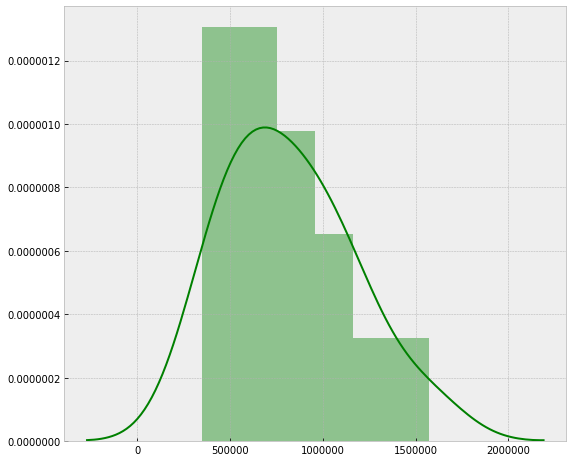

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(9, 8))
sns.distplot(df[['Housing Prices']], color='g', bins=6, hist_kws={'alpha': 0.4});

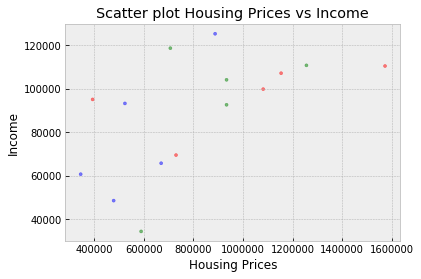

In [131]:
plt.scatter(df['Housing Prices'], df['Income'], s=np.pi*3, c=('red','green','blue'), alpha=0.5)
plt.title('Scatter plot Housing Prices vs Income')
plt.xlabel('Housing Prices')
plt.ylabel('Income')
plt.show()

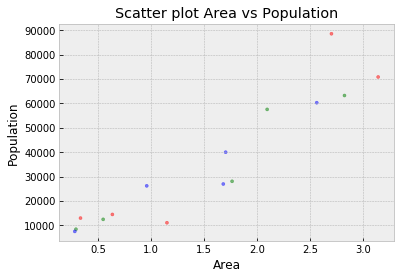

In [130]:
plt.scatter(df['Area'], df['Population'], s=np.pi*3, c=('red','green','blue'), alpha=0.5)
plt.title('Scatter plot Area vs Population')
plt.xlabel('Area')
plt.ylabel('Population')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6256e44b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f62564db278>]], dtype=object)

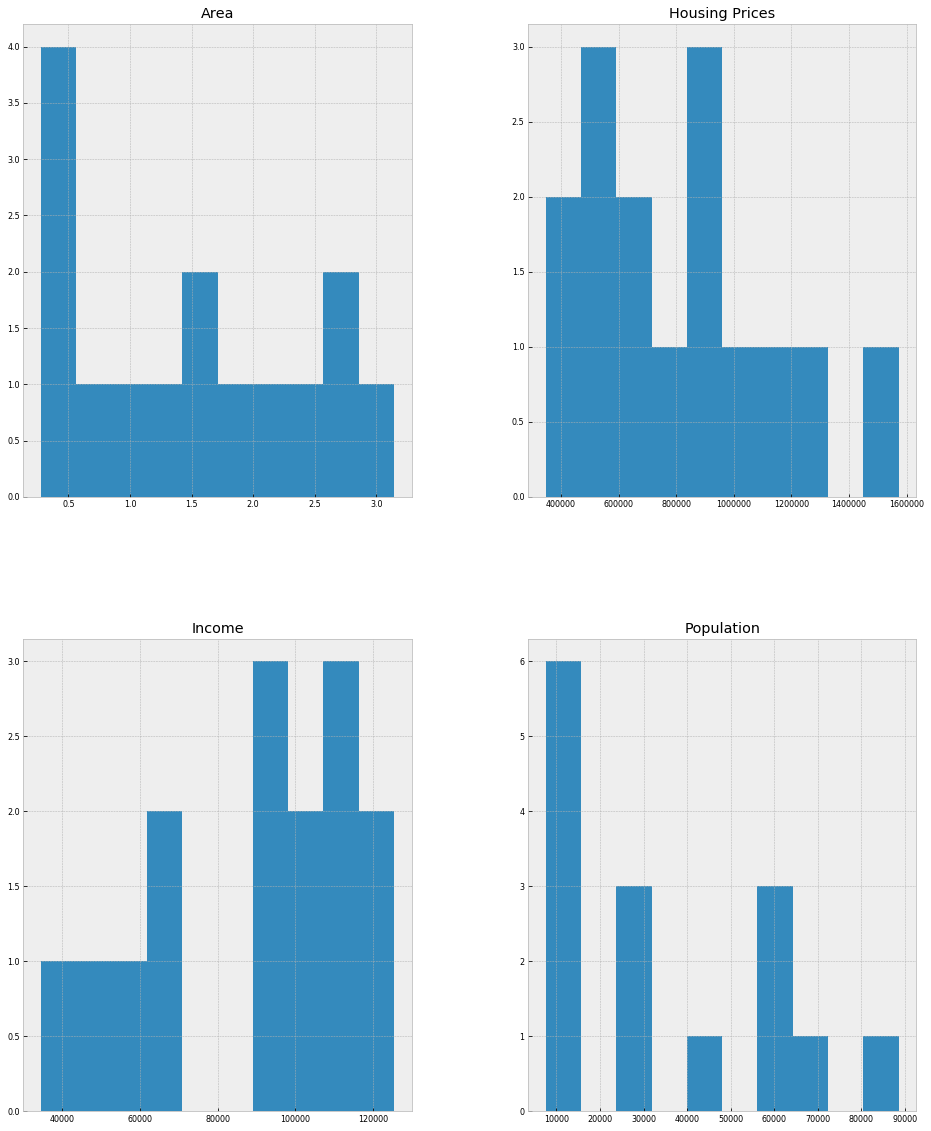

In [133]:
df.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

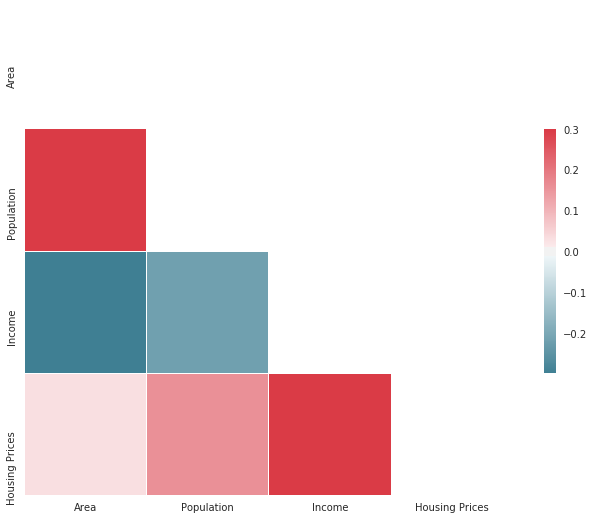

In [142]:
sns.set(style="white")

corr = df.corr() 
plt.figure(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})

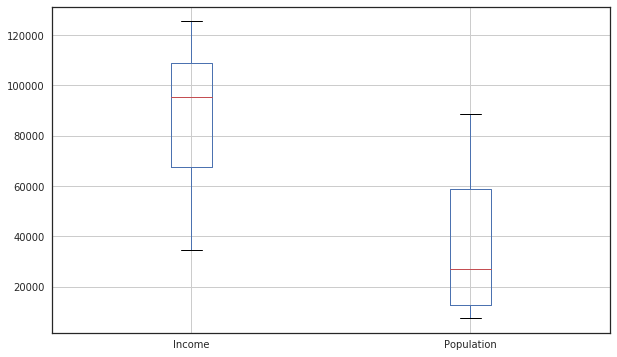

In [156]:
plt.figure(figsize = (10, 6))
ax = df.boxplot(column=['Income','Population'])

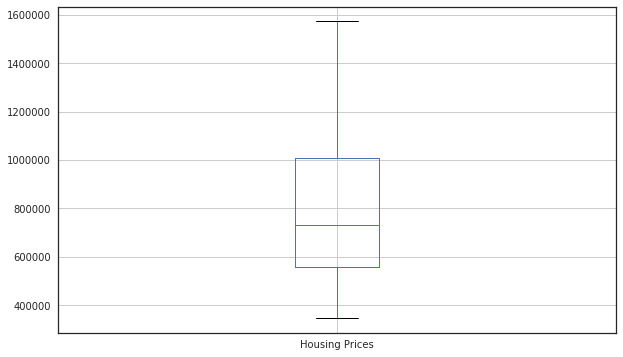

In [157]:
plt.figure(figsize = (10, 6))
ax1 = df.boxplot(column=['Housing Prices'])

In [158]:
df_chicago_new = df

In [164]:
df_chicago_new.drop(['Area', 'Population', 'Income', 'Housing Prices'], axis=1, inplace = True)

In [162]:
df_chicago_new.insert(1, "Latitude", [41.979, 41.836, 41.983, 42.005, 41.906, 41.794, 41.939, 41.921, 41.923, 41.900, 41.856, 41.907, 41.892, 41.882, 41.907], True)
df_chicago_new.insert(2, "Longitude", [-87.670, -87.648, -87.663, -87.814, -87.625, -87.593, -87.658, -87.647, -87.709, -87.634, -87.624, -87.637, -87.634, -87.644, -87.678], True)


In [165]:
df_chicago_new # Final dataframe ready for exploration

,Neighbourhood,Latitude,Longitude
0,Andersonville,41.979,-87.670
1,Bridgeport,41.836,-87.648
2,Edgewater,41.983,-87.663
3,Edison Park,42.005,-87.814
4,Gold Coast,41.906,-87.625
5,Hyde Park,41.794,-87.593
6,Lakeview,41.939,-87.658
7,Lincoln Park,41.921,-87.647
8,Logan Square,41.923,-87.709
9,Near North Side,41.900,-87.634


In [166]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



In [167]:
# create map of New York using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_chicago_new['Latitude'], df_chicago_new['Longitude'], df_chicago_new['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

<h2> Initializing instance of the Foursquare API for exploration

In [168]:
CLIENT_ID = 'JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI' # your Foursquare ID
CLIENT_SECRET = 'UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI
CLIENT_SECRET:UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV


<h4> As observed from the map, I have segemented our 15 neighbourhoods in 7 clusters, as follows:</h4>
    <ul>Cluster wise distribution</ul>
    <li>Cluster 1 - Gold Coast, Old Town, Near North Side, River North, West Loop </li>
    <li>Cluster 2 - Edgewater, Andersonville</li>
    <li>Cluster 3 - Lakeview, Lincoln Park</li>
    <li>Cluster 4 - Logan Square, Wicker Park</li>
    <li>Cluster 5 - Edison Park</li>
    <li>Cluster 6 - Bridgeport, Near South Side</li>
    <li>Cluster 7 - Hyde Park</li>

<h3> Exploration of Cluster 1 - 5 Neighbourhoods

In [202]:
neighbourhood_latitude = df_chicago_new.loc[12, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[12, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[12, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of River North are 41.892, -87.634.


In [203]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.892,-87.634&radius=2000&limit=200'

In [204]:
results = requests.get(url).json()

In [205]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [206]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Binny's Beverage Depot,Liquor Store,41.891414,-87.635293
1,Tanta Chicago,Peruvian Restaurant,41.891652,-87.632021
2,Trunk Club - Chicago,Men's Store,41.892130,-87.636658
3,Dollop Coffee Co.,Coffee Shop,41.893630,-87.634137
4,GT Fish and Oyster,Seafood Restaurant,41.891671,-87.633936
5,The Anti-Cruelty Society,Animal Shelter,41.891375,-87.632548
6,Sunda,Sushi Restaurant,41.890840,-87.631603
7,River North CrossFit,Gym,41.892948,-87.636047
8,Studio Three,Gym / Fitness Center,41.893999,-87.631373
9,Beatrix,New American Restaurant,41.891480,-87.630874


In [207]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [208]:
nearby_venues['categories'].nunique()

53

<h3> Exploration of Cluster 2 - Edgewater and Andersonville

In [209]:
neighbourhood_latitude = df_chicago_new.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[0, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Andersonville are 41.979, -87.67.


In [215]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.979,-87.67&radius=1000&limit=100'

In [216]:
results = requests.get(url).json()

In [217]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Lost Larson Bakery,Bakery,41.978617,-87.668411
1,First Slice Pie Café,Pie Shop,41.979819,-87.669500
2,George's Ice Cream & Sweets,Ice Cream Shop,41.978299,-87.668468
3,Calo Ristorante,Italian Restaurant,41.979427,-87.668237
4,The Brown Elephant,Thrift / Vintage Store,41.980193,-87.668672
5,Alleycat Comics,Comic Shop,41.978220,-87.668750
6,Kopi Café,Café,41.978612,-87.668298
7,Big Jones,Southern / Soul Food Restaurant,41.979509,-87.668251
8,A Taste of Heaven,Breakfast Spot,41.979873,-87.668305
9,Cheetah Gym,Gym,41.977550,-87.668570


In [218]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [219]:
nearby_venues['categories'].nunique() # Returns the number of unique values

63

<h3> Exploration of Cluster 3 - Lakeview and Lincoln Park

In [220]:
neighbourhood_latitude = df_chicago_new.loc[7, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[7, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[7, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Lincoln Park are 41.921, -87.647.


In [221]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.921,-87.647&radius=1000&limit=100'

In [222]:
results = requests.get(url).json()

In [223]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Oz Park,Park,41.920978,-87.644598
1,Toast,Breakfast Spot,41.921851,-87.648115
2,Café Ba-Ba-Reeba!,Tapas Restaurant,41.918921,-87.648718
3,Athenian Room,Greek Restaurant,41.921761,-87.649098
4,Swirlz Cupcakes,Cupcake Shop,41.923668,-87.646759
5,Read It & Eat,Bookstore,41.921305,-87.648716
6,Insomnia Cookies,Dessert Shop,41.923177,-87.645636
7,Kameya,Japanese Restaurant,41.921804,-87.648914
8,Chez Moi,French Restaurant,41.920102,-87.648675
9,interurban cafe & pastry,Bakery,41.918481,-87.649186


In [224]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [225]:
nearby_venues['categories'].nunique() # Returns the number of unique values

63

<h3> Exploration of Cluster 4 - Logan Square and Wicker Park

In [226]:
neighbourhood_latitude = df_chicago_new.loc[14, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[14, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[14, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Wicker Park are 41.907, -87.678.


In [227]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.907,-87.678&radius=500&limit=100'

In [228]:
results = requests.get(url).json()

In [229]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Wicker Park,Park,41.907960,-87.677267
1,The Violet Hour,Speakeasy,41.909048,-87.677631
2,Big Star,Taco Place,41.909229,-87.677279
3,Dove's Luncheonette,Diner,41.909524,-87.677447
4,The Wormhole Coffee,Coffee Shop,41.908393,-87.674611
5,Jeni's Splendid Ice Creams,Ice Cream Shop,41.908827,-87.674944
6,Lou Malnati's Pizzeria,Pizza Place,41.908847,-87.677807
7,Wicker Park Farmers Market,Farmers Market,41.908187,-87.677146
8,Stan's Donuts & Coffee,Donut Shop,41.909927,-87.677462
9,Mojo Spa,Spa,41.908558,-87.674642


In [230]:
nearby_venues['categories'].nunique() # Returns the number of unique values

69

<h3> Exploration of Cluster 5 - Edison Park

In [231]:
neighbourhood_latitude = df_chicago_new.loc[3, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[3, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[3, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Edison Park are 42.005, -87.814.


In [232]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=42.005,-87.814&radius=500&limit=100'

In [233]:
results = requests.get(url).json()

In [234]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Tony's Italian Deli and Subs,Deli / Bodega,42.002882,-87.816443
1,Zia's Trattoria,Italian Restaurant,42.002697,-87.816013
2,The Curragh,Pub,42.002902,-87.816361
3,Nonno Pino's,Italian Restaurant,42.003132,-87.816886
4,Firewater Saloon,Bar,42.002468,-87.816378
5,Giordano's,Pizza Place,42.003149,-87.816317
6,Happy Foods,Grocery Store,42.004377,-87.818557
7,Café Touché,French Restaurant,42.003467,-87.817173
8,Armand's Pizzaria,Pizza Place,42.002694,-87.816091
9,Don Juan's,Mexican Restaurant,42.003342,-87.817163


In [235]:
nearby_venues['categories'].nunique() # Returns the number of unique values

21

<h3> Exploration of Cluster 6 - Bridgeport and Near South Side

In [236]:
neighbourhood_latitude = df_chicago_new.loc[10, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[10, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[10, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Near South Side are 41.856, -87.624.


In [237]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.856,-87.624&radius=500&limit=100'

In [238]:
results = requests.get(url).json()

In [239]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,La Cantina Grill,Mexican Restaurant,41.856310,-87.623778
1,"Willie Dixon's Blues Heaven Foundation, Histor...",Historic Site,41.853524,-87.623933
2,Opart Thai House,Thai Restaurant,41.856084,-87.627154
3,The Jibarito Stop,Food Truck,41.856281,-87.622174
4,Chicago Women's Park & Gardens,Park,41.857779,-87.622074
5,Cafe Bionda,Italian Restaurant,41.855769,-87.627162
6,South Coast Sushi,Sushi Restaurant,41.858927,-87.623974
7,Glessner House Museum,Museum,41.857784,-87.621422
8,Chicago Oyster House,Seafood Restaurant,41.855595,-87.622232
9,Pizano's Pizza & Pasta,Pizza Place,41.854028,-87.622302


In [240]:
nearby_venues['categories'].nunique() # Returns the number of unique values

45

<h3> Exploration of Cluster 7 - Hyde Park

In [241]:
neighbourhood_latitude = df_chicago_new.loc[5, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = df_chicago_new.loc[5, 'Longitude'] # neighborhood longitude value

neighbourhood_name = df_chicago_new.loc[5, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Hyde Park are 41.794, -87.593.


In [242]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JKAVUXXCQKZM05LGWJ04G2OP0TVHYIM2GOXLEB3LDYEPFCAI&client_secret=UCQR35FCKW1GYTLQBQABZS2FHTDQ1J5WEEDUQCZ41PHGZGRV&v=20180605&ll=41.794,-87.593&radius=500&limit=100'

In [243]:
results = requests.get(url).json()

In [244]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,57th Street Books,Bookstore,41.791469,-87.594591
1,Medici on 57th,Bakery,41.791379,-87.593708
2,Parker's Pet Spa & Boutique,Pet Store,41.795226,-87.593185
3,"Noodles, Etc.",Noodle House,41.791465,-87.593370
4,B'GABS GOODIES,Vegetarian / Vegan Restaurant,41.791749,-87.589542
5,Chaturanga Holistic Fitness,Yoga Studio,41.794942,-87.588171
6,Nichols Park,Park,41.797502,-87.593628
7,Salonica,Diner,41.791529,-87.590152
8,57th St Wines,Wine Shop,41.791599,-87.589737
9,Bonjour Cafe,Café,41.795435,-87.588439


In [245]:
nearby_venues['categories'].nunique() # Returns the number of unique values

28

<b>Now that we have explored our clusters, we would list down the venues within a specified radius for all our neighbourhoods

In [247]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [248]:
chicago_venues = getNearbyVenues(names=df_chicago_new['Neighbourhood'],
                                   latitudes=df_chicago_new['Latitude'],
                                   longitudes=df_chicago_new['Longitude']
                                  )

Andersonville
Bridgeport
Edgewater
Edison Park
Gold Coast
Hyde Park
Lakeview
Lincoln Park
Logan Square
Near North Side
Near South Side
Old Town
River North
West Loop
Wicker Park


In [249]:
chicago_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Andersonville,41.979,-87.670,Lost Larson Bakery,41.978617,-87.668411,Bakery
1,Andersonville,41.979,-87.670,First Slice Pie Café,41.979819,-87.669500,Pie Shop
2,Andersonville,41.979,-87.670,George's Ice Cream & Sweets,41.978299,-87.668468,Ice Cream Shop
3,Andersonville,41.979,-87.670,Calo Ristorante,41.979427,-87.668237,Italian Restaurant
4,Andersonville,41.979,-87.670,The Brown Elephant,41.980193,-87.668672,Thrift / Vintage Store
5,Andersonville,41.979,-87.670,Alleycat Comics,41.978220,-87.668750,Comic Shop
6,Andersonville,41.979,-87.670,Kopi Café,41.978612,-87.668298,Café
7,Andersonville,41.979,-87.670,Big Jones,41.979509,-87.668251,Southern / Soul Food Restaurant
8,Andersonville,41.979,-87.670,A Taste of Heaven,41.979873,-87.668305,Breakfast Spot
9,Andersonville,41.979,-87.670,Cheetah Gym,41.977550,-87.668570,Gym


<h3>Venue counts according to Neighbourhoods

In [250]:
chicago_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Andersonville,100,100,100,100,100,100
Bridgeport,81,81,81,81,81,81
Edgewater,100,100,100,100,100,100
Edison Park,36,36,36,36,36,36
Gold Coast,100,100,100,100,100,100
Hyde Park,100,100,100,100,100,100
Lakeview,100,100,100,100,100,100
Lincoln Park,100,100,100,100,100,100
Logan Square,100,100,100,100,100,100


In [251]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 216 uniques categories.


<h2>Cluster Analysis - Chicago Neighbourhoods

In [252]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
chicago_onehot['Neighbourhood'] = chicago_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Andersonville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Andersonville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Andersonville,0,0,0,0,0,0,0,0,0,0,0,0,0

In [253]:
df_chicago_new = chicago_onehot.groupby('Neighbourhood').mean().reset_index()
df_chicago_new

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Andersonville,0.00,0.01,0.00,0.000000,0.010000,0.00,0.03,0.00,0.00,0.000000,0.00,0.00,0.03,0.00,0.000000,0.00,0.00,0.00,0.010000,0.000000,0.030000,0.000000,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.040000,0.03,0.00,0.000000,0.020000,0.00,0.000000,0.00,0.020000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.050000,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,0.00,0.00,0.00,0.010000,0.010000,0.01,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.010000,0.00,0.010000,0.030000,0.010000,0.01,0.000000,0.00,0.00,0.00,0.01,0.00,0.010000,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.040000,0.000000,0.00,0.00,0.00,0.00,0.020000,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.010000,0.00,0.030000,0.03,0.01,0.000000,0.00,0.00,0.01,0.00,0.000000,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.

<h3> Listing top 5 venues for each neighbourhood </h3>

In [255]:
num_top_venues = 5

for hood in df_chicago_new['Neighbourhood']:
    print("----"+hood+"----")
    temp = df_chicago_new[df_chicago_new['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Andersonville----
                       venue  freq
0                Coffee Shop  0.05
1             Breakfast Spot  0.04
2         Italian Restaurant  0.04
3              Grocery Store  0.03
4  Middle Eastern Restaurant  0.03


----Bridgeport----
                venue  freq
0  Chinese Restaurant  0.09
1  Mexican Restaurant  0.06
2         Art Gallery  0.06
3         Pizza Place  0.05
4       Hot Dog Joint  0.05


----Edgewater----
                venue  freq
0         Coffee Shop  0.06
1  Mexican Restaurant  0.04
2      Sandwich Place  0.04
3       Grocery Store  0.04
4    Asian Restaurant  0.04


----Edison Park----
                venue  freq
0                 Bar  0.08
1  Italian Restaurant  0.08
2                Park  0.08
3          Donut Shop  0.06
4              Bakery  0.06


----Gold Coast----
                 venue  freq
0                Hotel  0.07
1  American Restaurant  0.06
2   Italian Restaurant  0.06
3                  Gym  0.05
4             Boutique  0.04


----

In [256]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [257]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = df_chicago_new['Neighbourhood']

for ind in np.arange(df_chicago_new.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_chicago_new.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andersonville,Coffee Shop,Italian Restaurant,Breakfast Spot,Asian Restaurant,Grocery Store,Bar,Antique Shop,Sandwich Place,Middle Eastern Restaurant,Mexican Restaurant
1,Bridgeport,Chinese Restaurant,Mexican Restaurant,Art Gallery,Pizza Place,Hot Dog Joint,Bar,Sporting Goods Shop,Grocery Store,Wings Joint,Pharmacy
2,Edgewater,Coffee Shop,Sandwich Place,Grocery Store,Asian Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Lounge,Breakfast Spot,Gym
3,Edison Park,Park,Italian Restaurant,Bar,Pizza Place,Donut Shop,Bakery,Bus Station,Spa,Shipping Store,Seafood Restaurant
4,Gold Coast,Hotel,Italian Restaurant,American Restaurant,Gym,Boutique,Coffee Shop,Women's Store,Salon / Barbershop,Café,Steakhouse


<h2> Clustering Neighbourhoods for Chicago

In [271]:
# set number of clusters
kclusters = 3

df_chicago_new_clustering = df_chicago_new.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_chicago_new_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 2, 1, 0, 0, 0, 0, 1], dtype=int32)

In [274]:
# add clustering labels
#neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_chicago_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
chicago_merged.insert(1, "Latitude", [41.979, 41.836, 41.983, 42.005, 41.906, 41.794, 41.939, 41.921, 41.923, 41.900, 41.856, 41.907, 41.892, 41.882, 41.907], True)
chicago_merged.insert(2, "Longitude", [-87.670, -87.648, -87.663, -87.814, -87.625, -87.593, -87.658, -87.647, -87.709, -87.634, -87.624, -87.637, -87.634, -87.644, -87.678], True)

chicago_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andersonville,41.979,-87.670,0.0,0.01,0.0,0.000000,0.010000,0.0,0.03,0.0,0.0,0.000000,0.0,0.0,0.03,0.0,0.000000,0.00,0.0,0.0,0.010000,0.000000,0.030000,0.000000,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.040000,0.03,0.0,0.000000,0.020000,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.050000,0.0,0.0,0.01,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.010000,0.00,0.00,0.0,0.0,0.010000,0.010000,0.01,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.01,0.00,0.01,0.0,0.01,0.0,0.010000,0.00,0.010000,0.030000,0.010000,0.01,0.000000,0.00,0.0,0.00,0.01,0.0,0.010000,0.01,0.00,0.0,0.01,0.00,0.0,0.01,0.0,0.01,0.04000

In [275]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighbourhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2> Examining Clusters for Chicago - 15 Neihgbourhoods

<h3> Cluster 1

In [276]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Latitude,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,41.979,0.00,0.0,0.01,0.0,0.03,0.00,0.00,0.00,0.00,0.00,0.03,0.0,0.0,0.00,0.00,0.00,0.01,0.0,0.03,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.04,0.03,0.00,0.0,0.02,0.00,0.0,0.00,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0.00,0.0,0.01,0.01,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.01,0.0,0.01,0.00,0.01,0.00,0.01,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.0,0.0,0.01,0.00,0.00,0.01,0.00,0.01,0.04,0.00,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.0,0.01,0.02,0.00,0.00,0.01,0.01,0.00,0.03,0.03,0.01,0.0,0.00,0.0,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0

<h3> Cluster 2

In [277]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Latitude,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,41.906,0.00,0.0,0.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.04,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.04,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.01,0.01,0.01,0.0,0.01,0.01,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.05,0.00,0.0,0.01,0.0,0.01,0.0,0.0,0.00,0.07,0.02,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.06,0.00,0.00,0.01,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.0,0.0,0.00,0.01,0.01,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.02,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.0,0.0,0.02,0.01,0.0,0.0,0.0,0.

<h3> Cluster 3

In [278]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Latitude,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dry Cleaner,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Floating Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,41.836,0.0,0.012346,0.012346,0.0,0.0,0.0,0.0,0.061728,0.0,0.0,0.00,0.00,0.012346,0.0,0.0,0.0,0.024691,0.012346,0.037037,0.012346,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.012346,0.00,0.00,0.012346,0.012346,0.0,0.000000,0.0,0.012346,0.00,0.00,0.00,0.0,0.086420,0.0,0.0,0.00,0.024691,0.0,0.0,0.0,0.0,0.012346,0.0,0.0,0.0,0.0,0.0,0.012346,0.0,0.0,0.00,0.00,0.012346,0.012346,0.0,0.0,0.012346,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012346,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012346,0.0,0.000000,0.037037,0.000000,0.00,0.012346,0.0,0.00,0.0,0.0,0.0,0.049383,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.012346,0.012346,0.0,0.0,0.00,0.0,0.012346,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.012346,0.0,0.061728,0.0,0.0,0.0